# Conditional components
We have seen how loggers and absorption loggers can reveal what is going on during a simulation with the Union components. These results give us some understanding of how the final results came to be so complex, but still it is difficult to connect an individual feature in the results to a cause within the simulated system.

The Union components offer a solution to this problem through its last class of components: conditional components. Conditional components are linked to absorption loggers and loggers and make their ability to record data for a given ray conditional. At the end of the simulation of each ray, the conditional component get the state of the ray, and can check if some condition is true or false.

This means one can define a conditional component that correspond to an area of our measured data and modify a number of loggers to only show rays that contribute to that data!

## The current conditional components
These always need to target a logger and will modify when it record data.

| Conditional component                   | Condition                                          |
| :---                                    |    :----                                           |
| Union_conditional_standard              | time, energy and scattering order limits           |
| Union_conditional_PSD                   | requires hitting a rectangular area and time limit |

## Our example with diamond sphere in aluminium shell
This example includes a number of loggers already.

In [1]:
import mcstasscript as ms
instrument = ms.McStas_instr("Union_demo", input_path="run_folder")
instrument.settings(output_path="data_folder/union_demo")

instrument.add_component("init", "Union_init")

Al_incoherent = instrument.add_component("Al_incoherent", "Incoherent_process")
Al_incoherent.set_parameters(sigma=4*0.0082, unit_cell_volume=66.4)

Al_powder = instrument.add_component("Al_powder", "Powder_process")
Al_powder.reflections = '"Al.laz"'

Al = instrument.add_component("Al", "Union_make_material")
Al.process_string = '"Al_incoherent,Al_powder"'
Al.my_absorption = 100*4*0.231/66.4

process = instrument.add_component("diamond_incoherent", "Incoherent_process")
process.set_parameters(sigma=8*0.001, unit_cell_volume=45.39)

instrument.add_parameter("diamond_phi", value=0, comment="Rotation of diamond lattice around z [deg]")
crystal_process = instrument.add_component("diamond_crystal", "Single_crystal_process")
crystal_process.set_parameters(mosaic=20, reflections='"C_diamond.lau"',
                               ax=3.567, by=3.567, cz=3.567,)
crystal_process.set_ROTATED([0, 0, "diamond_phi"])

diamond = instrument.add_component("diamond", "Union_make_material")
diamond.process_string = '"diamond_incoherent,diamond_crystal"'
diamond.my_absorption = 100*8*0.0035/45.39

sample_position = instrument.add_component("sample_position", "Arm")
sample_position.set_AT([0,0,1])

instrument.add_parameter("A3", value=0, comment="Rotation of sphere around y [deg]")
sphere = instrument.add_component("sphere", "Union_sphere")
sphere.radius = 0.01
sphere.material_string = '"diamond"'
sphere.priority = 10
sphere.set_AT(0, RELATIVE=sample_position)
sphere.set_ROTATED([0, "A3", 0], RELATIVE=sample_position)

shell = instrument.add_component("shell", "Union_cylinder")
shell.set_parameters(radius=0.05, yheight=0.12,
                     material_string = '"Al"', priority=3,
                     p_interact=0.2)
shell.set_AT(0, RELATIVE=sample_position)

shell_vacuum = instrument.add_component("shell_vacuum", "Union_cylinder")
shell_vacuum.set_parameters(radius=shell.radius - 0.01, yheight=shell.yheight - 0.01,
                            material_string = '"Vacuum"', priority=5)
shell_vacuum.set_AT([0, 0, 0], RELATIVE=sample_position)

source = instrument.add_component("source", "Source_div")
source.set_parameters(focus_aw=0.3, focus_ah=0.3,
                      xwidth=0.005, yheight=0.005,
                      flux=1E12)
source.set_AT(-1, RELATIVE=sample_position)

source.lambda0 = instrument.add_parameter("wavelength", value=5.0,
                                          comment="Wavelength in [Ang]")
source.dlambda = instrument.add_parameter("wavelength_half_width", value=4.5,
                                          comment="Wavelength half width in [Ang]")

master = instrument.add_component("master", "Union_master")
stop = instrument.add_component("stop", "Union_stop")

logger_time = instrument.add_component("logger_time_all", "Union_logger_1D", before=master)
logger_time.set_parameters(min_value=0, max_value=0.003, n1=600, filename='"scattering_time.dat"')

logger_time = instrument.add_component("logger_time_shell", "Union_logger_1D", before=master)
logger_time.set_parameters(min_value=0, max_value=0.003, n1=600, filename='"scattering_time_shell.dat"',
                           target_geometry='"shell"')

logger_zx = instrument.add_component("logger_space_zx", "Union_logger_2D_space",
                                     before=master, RELATIVE=sample_position)
logger_zx.set_parameters(D_direction_1='"z"', D1_min=-0.07, D1_max=0.07, n1=300,
                         D_direction_2='"x"', D2_min=-0.07, D2_max=0.07, n2=300,
                         filename='"logger_zx.dat"')

logger_zx = instrument.add_component("logger_space_zx_1", "Union_logger_2D_space",
                                     before=master, RELATIVE=sample_position)
logger_zx.set_parameters(D_direction_1='"z"', D1_min=-0.07, D1_max=0.07, n1=300,
                         D_direction_2='"x"', D2_min=-0.07, D2_max=0.07, n2=300,
                         filename='"logger_zx_1.dat"', order_total=1)

logger_zx = instrument.add_component("logger_space_zx_2", "Union_logger_2D_space",
                                     before=master, RELATIVE=sample_position)
logger_zx.set_parameters(D_direction_1='"z"', D1_min=-0.07, D1_max=0.07, n1=300,
                         D_direction_2='"x"', D2_min=-0.07, D2_max=0.07, n2=300,
                         filename='"logger_zx_2.dat"', order_total=2)

logger_zy = instrument.add_component("logger_space_zy", "Union_logger_2D_space",
                                     before=master, RELATIVE=sample_position)
logger_zy.set_parameters(D_direction_1='"z"', D1_min=-0.07, D1_max=0.07, n1=300,
                         D_direction_2='"y"', D2_min=-0.07, D2_max=0.07, n2=300,
                         filename='"logger_zy.dat"')

logger_xy = instrument.add_component("logger_space_xy", "Union_logger_2D_space",
                                     before=master, RELATIVE=sample_position)
logger_xy.set_parameters(D_direction_1='"x"', D1_min=-0.06, D1_max=0.07, n1=300,
                         D_direction_2='"y"', D2_min=-0.07, D2_max=0.07, n2=300,
                         filename='"logger_xy.dat"') 

logger_2DQ = instrument.add_component("logger_2DQ", "Union_logger_2DQ", before=master)
logger_2DQ.set_parameters(Q_direction_1 = '"z"', Q1_min = -8.0, Q1_max = 8.0, n1 = 500,
                         Q_direction_2 = '"x"', Q2_min = -8.0, Q2_max = 8.0, n2 = 500,
                         filename = '"logger_2DQ.dat"')

logger_2DQ = instrument.copy_component("logger_2DQ_shell", "logger_2DQ", before=master)
logger_2DQ.set_parameters(filename = '"logger_2DQ_Al.dat"', target_geometry='"shell"')

logger_2DQ = instrument.copy_component("logger_2DQ_Al_inc", "logger_2DQ", before=master)
logger_2DQ.set_parameters(filename = '"logger_2DQ_Al_inc.dat"', target_geometry='"shell"',
                          target_process='"Al_incoherent"')

logger_2DQ = instrument.copy_component("logger_2DQ_Al_pow", "logger_2DQ", before=master)
logger_2DQ.set_parameters(filename = '"logger_2DQ_Al_pw.dat"', target_geometry='"shell"',
                          target_process='"Al_powder"')

logger_2DQ = instrument.copy_component("logger_2DQ_Diamond", "logger_2DQ", before=master)
logger_2DQ.set_parameters(filename = '"logger_2DQ_Diamond.dat"', target_geometry='"sphere"')

logger_2DQ = instrument.copy_component("logger_2DQ_Diamond_inc", "logger_2DQ", before=master)
logger_2DQ.set_parameters(filename = '"logger_2DQ_Diamond_inc.dat"', target_geometry='"sphere"',
                          target_process='"diamond_incoherent"')

logger_2DQ = instrument.copy_component("logger_2DQ_Diamond_single", "logger_2DQ", before=master)
logger_2DQ.set_parameters(filename = '"logger_2DQ_Diamond_single.dat"', target_geometry='"sphere"',
                          target_process='"diamond_crystal"')

instrument.add_declare_var("double", "t_min")
instrument.add_declare_var("double", "t_max")

instrument.append_initialize("t_min = (wavelength - wavelength_half_width)*(1.0 - 0.18 + 0.5)/(K2V*2*PI);")
instrument.append_initialize("t_max = (wavelength + wavelength_half_width)*(1.0 + 0.28 + 0.5)/(K2V*2*PI);")

instrument.add_declare_var("char", "options", array=256)
instrument.append_initialize('sprintf(options,"banana, theta limits=[-180,180] bins=180, t limits=[%g %g] bins=300",t_min,t_max);')

banana_detector = instrument.add_component("banana_tof_detector", "Monitor_nD")
banana_detector.set_RELATIVE(sample_position)
banana_detector.xwidth = 1
banana_detector.yheight = 0.2
banana_detector.restore_neutron = 1
options = "options"
banana_detector.options = options
banana_detector.filename = '"tof_b.dat"'

banana_detector = instrument.add_component("banana_detector", "Monitor_nD")
banana_detector.set_RELATIVE(sample_position)
banana_detector.set_parameters(xwidth = 1.0, yheight = 0.2, filename='"banana.dat"', restore_neutron=1,
                               options='"banana, theta limits=[-180,180] bins=180"')

L_monitor = instrument.add_component("L_monitor", "L_monitor")
L_monitor.set_AT(0.3, RELATIVE=sample_position)
L_monitor.set_parameters(xwidth=0.3, yheight=0.3,
                         Lmin="wavelength - wavelength_half_width",
                         Lmax="wavelength + wavelength_half_width",
                         nL=300, filename='"l_mon.dat"', restore_neutron=1)

The following components are found in the work_directory / input_path:
     Union_sphere.comp
     Texture_process.comp
     Union_cone.comp
     Union_stop.comp
     Union_box.comp
     Single_crystal_process.comp
     Union_abs_logger_2D_space.comp
     Union_logger_2D_kf.comp
     Union_init.comp
     Template_process.comp
     PhononSimple_process.comp
     Union_conditional_standard.comp
     Union_abs_logger_1D_space.comp
     Union_abs_logger_event.comp
     Union_abs_logger_1D_space_event.comp
     Non_process.comp
     Union_abs_logger_1D_space_tof.comp
     Union_logger_2D_space.comp
     Union_conditional_PSD.comp
     Union_master.comp
     AF_HB_1D_process.comp
     Union_logger_2D_kf_time.comp
     Union_master_GPU.comp
     Union_cylinder.comp
     Union_abs_logger_1D_space_tof_to_lambda.comp
     Powder_process.comp
     Union_make_material.comp
     Incoherent_process.comp
     Union_logger_1D.comp
     Union_logger_3D_space.comp
     IncoherentPhonon_process.comp
    

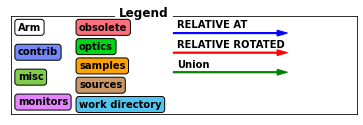

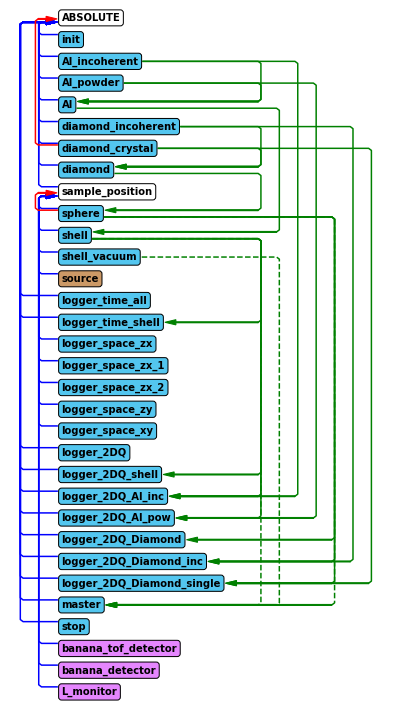

In [2]:
instrument.show_diagram()

## Before adding a conditional
It is good practice to have a copy of each logger the conditional will affect that is left unaffected to be able to compare. Some loggers are copied here for conditional!

In [3]:
logger_2DQ = instrument.copy_component("logger_2DQ_con", "logger_2DQ", after="logger_2DQ")
logger_2DQ.filename = '"logger_2DQ_con.dat"'

logger_zx = instrument.copy_component("logger_space_zx_con", "logger_space_zx",
                                      after="logger_space_zx", RELATIVE=sample_position)
logger_zx.filename='"logger_zx_con.dat"'

logger_zx = instrument.copy_component("logger_space_zx_1_con", "logger_space_zx_1",
                                      after="logger_space_zx_1", RELATIVE=sample_position)
logger_zx.filename='"logger_zx_1_con.dat"'

logger_zx = instrument.copy_component("logger_space_zx_2_con", "logger_space_zx_2",
                                      after="logger_space_zx_2", RELATIVE=sample_position)
logger_zx.filename='"logger_zx_2_con.dat"'

logger_zy = instrument.copy_component("logger_space_zy_con", "logger_space_zy",
                                      after="logger_space_zy", RELATIVE=sample_position)
logger_zy.filename='"logger_zy_con.dat"'

logger_xy = instrument.copy_component("logger_space_xy_con", "logger_space_xy",
                                      after="logger_space_xy", RELATIVE=sample_position)
logger_xy.filename='"logger_xy_con.dat"'

### Adding a conditional
We will add the Union_conditional_PSD component.

In [4]:
con_dir = instrument.add_component("conditional_direction", "Arm", before=master)
con_dir.set_AT(0, "sample_position")
rot_y = instrument.add_parameter("conditional_angle", value=0,
                                 comment="Angle conditional PSD is placed at [deg]")
con_dir.set_ROTATED([0, rot_y, 0], "sample_position")

instrument.add_parameter("conditional_mean_time", value=0.0003, comment="Time center for conditional [s]")
instrument.add_parameter("conditional_spread_time", value=0.00003, comment="Time spread for conditional [s]")

con = instrument.add_component("conditional", "Union_conditional_PSD", before=master)
con.set_parameters(xwidth=0.04, yheight=0.2,
                   time_min="conditional_mean_time - 0.5*conditional_spread_time",
                   time_max="conditional_mean_time + 0.5*conditional_spread_time",
                   target_loggers='"logger_2DQ_con,logger_space_zx_con,logger_space_zx_1_con,logger_space_zx_2_con,logger_space_zy_con,logger_space_xy_con"')
con.set_AT(banana_detector.xwidth/2, RELATIVE=con_dir)

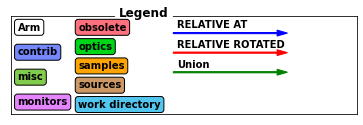

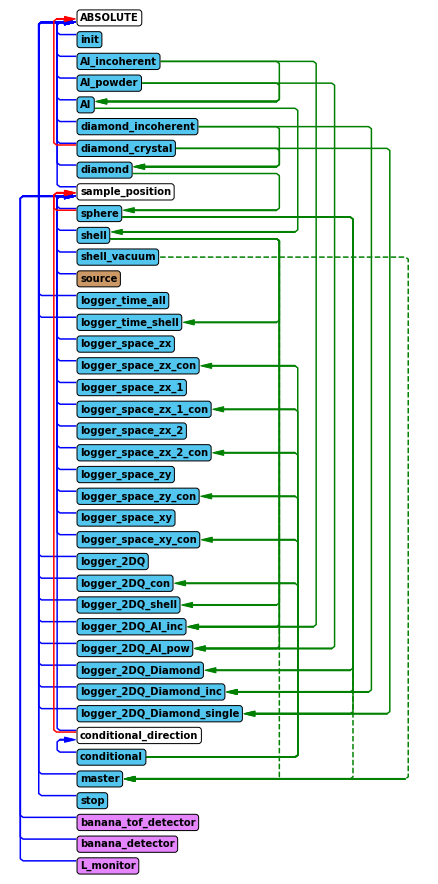

In [5]:
instrument.show_diagram()

### Limiting any monitor to conditionals for checking

In [6]:
logger_2DQ.logger_conditional_extend_index = 1

instrument.add_user_var("int", "conditional_flag", comment="flag for conditional component")
master.append_EXTEND("conditional_flag = logger_conditional_extend_array[1];")

banana_con = instrument.copy_component("banana_tof_detector_con", "banana_tof_detector",
                                      after="banana_tof_detector", RELATIVE=sample_position)
banana_con.filename='"banana_tof_con.dat"'
banana_con.set_WHEN("conditional_flag")

In [7]:
%matplotlib widget
import mcstasscript.jb_interface as ms_widget

In [8]:
ms_widget.show(instrument)

### Using conditionals in animations

In [9]:
instrument.add_declare_var("double", "t_min_system")
instrument.add_declare_var("double", "t_max_system")
instrument.append_initialize("t_min_system = (wavelength - wavelength_half_width)*(1.0 - 0.071)/(K2V*2*PI);")
instrument.append_initialize("t_max_system = (wavelength + wavelength_half_width)*(1.0 + 0.28)/(K2V*2*PI);")

logger_zy = instrument.add_component("logger_2D_space_time_con", "Union_logger_2D_space_time",
                                     before=con, RELATIVE=sphere)
logger_zy.set_parameters(D_direction_1='"z"', D1_min=-0.07, D1_max=0.07, n1=300,
                         D_direction_2='"y"', D2_min=-0.07, D2_max=0.07, n2=300,
                         time_bins=70, time_min="t_min_system", time_max="t_max_system",
                         filename='"logger_zy_time_con.dat"')

con.target_loggers='"logger_2D_space_time_con,logger_2DQ_con,logger_space_zx_con,logger_space_zx_1_con,logger_space_zx_2_con,logger_space_zy_con,logger_space_xy_con"'

### Run simulation

In [10]:
#instrument.set_parameters(diamond_phi=45, A3=1, wavelength=2.435, wavelength_half_width=0.03, 
#                          conditional_angle=-103, conditional_mean_time=0.000975, 3e-05)
instrument.settings(ncount=5E7, mpi=6, force_compile=True)
data = instrument.backengine()


INFO: Using directory: "/Users/madsbertelsen/PaNOSC/McStasScript/github/McStasScript-notebooks/McStas_Advanced_Design_School/2_Union_day/data_folder/union_demo_21"
INFO: Regenerating c-file: Union_demo.c
         Move them into an INITIALIZE section. May fail at compile.
CFLAGS= -I@MCCODE_LIB@/share/ -DFUNNEL 
          
-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:
Component master is NOACC, CPUONLY=1
-> FUNNEL mode enabled, SPLIT within buffer.
-> CPU section from component master
-> GPU kernel from component stop

-----------------------------------------------------------
INFO: Recompiling: ./Union_demo.out
./Union_demo.c:593:11: warning: 'MC_RAND_MAX' macro redefined [-Wmacro-redefined]
#  define MC_RAND_MAX ULONG_MAX
          ^
./Union_demo.c:565:11: note: previous definition is here
#  define MC_RAND_MAX ((

### Make animation

In [11]:
ani_data = ms.name_search("logger_2D_space_time_con", data)
    
ms.make_animation(ani_data, filename="animation_demo", fps=3,
                  log=True, colormap="Reds", orders_of_mag=6, figsize=(8, 5))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

2022-12-12 11:28:42,430 WARNING:MovieWriter imagemagick unavailable; using Pillow instead.


Saving animation with filename : "animation_demo.gif"


# Union overview
In total there are 8 classes of Union components that can be linked together in order to perform the simulation.

| Component class         | Links to                       | Purpose                                    |
| :---                    |    :----                       |    :----                                   |
| Process components      |                                | Describe scattering process                |
| Union_make_material     | List of process components     | Collect process and absorption to material |
| Geometry components     | Material definition            | Place a geometry with selected material    |
| Logger components       | Optionally geometry / process  | Record scattering in Union system          |
| Abs_logger components   | Optionally geometry / process  | Record absorption in Union system          |
| Conditional components  | Logger or Abs_logger           | Place final condition on recording         |
| Union_master            | Geometries (automatic linking) | Simulation engine                          |
| Union_init / Union_stop |                                | Needed in McStas 3.X at start / end        |




![alt](figures/power_point_figures/Slide13.png)

## Conclusion
The Union components is a powerful addition to McStas that allow complex simulations with simple tools. The advantages are:
- Splits responsibility into geometry, physics and simulation engine
- Modular physics description (expandable)
- Allows overlapping geometry and hollow systems like cryostats
- Full multiple scattering
- Comprehensive logging tools
- System for tracking interesting features (Conditional components)
- Can be used to simulate detector systems

Still to do:
- Polarization not supported
- Gravity not supported
- Surface effects

## Quiz and exercise
Now its time for you to do a quiz about the Union components and use them to build an instrument. The quiz is called Union_quiz and is available in the McStasScript-notebooks. If only the solution is available, a git pull will be needed from the McStasScript-notebooks folder.